In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set the seed for numpy
np.random.seed(42)

# Set plots style
plt.style.use('seaborn-v0_8')

# Dataset

In [3]:
# import the dataset
df = pd.read_csv('Dataset/leaf.csv',names=['Class','Specimen Number','Eccentricity','Aspect Ratio','Elongation','Solidity','Stochastic Convexity','Isoperimetric Factor','Maximal Indentation Depth','Lobedness','Average Intensity','Average Contrast','Smoothness','Third moment','Uniformity','Entropy'])

# Drop the Specimen Number column
df.drop('Specimen Number', axis=1, inplace=True)

# Print
df.head()

,Class,Eccentricity,Aspect Ratio,Elongation,Solidity,Stochastic Convexity,Isoperimetric Factor,Maximal Indentation Depth,Lobedness,Average Intensity,Average Contrast,Smoothness,Third moment,Uniformity,Entropy
0,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.83592,0.004657,0.003947,0.047790,0.127950,0.016108,0.005232,0.000275,1.17560
1,1,0.74173,1.5257,0.36116,0.98152,0.99825,0.79867,0.005242,0.005002,0.024160,0.090476,0.008119,0.002708,0.000075,0.69659
2,1,0.76722,1.5725,0.38998,0.97755,1.00000,0.80812,0.007457,0.010121,0.011897,0.057445,0.003289,0.000921,0.000038,0.44348
3,1,0.73797,1.4597,0.35376,0.97566,1.00000,0.81697,0.006877,0.008607,0.015950,0.065491,0.004271,0.001154,0.000066,0.58785
4,1,0.82301,1.7707,0.44462,0.97698,1.00000,0.75493,0.007428,0.010042,0.007938,0.045339,0.002051,0.000560,0.000024,0.34214


In [4]:
# Select the columns to be standardized
columns_to_standardize = ['Eccentricity', 'Aspect Ratio', 'Elongation', 'Solidity', 'Stochastic Convexity',
                          'Isoperimetric Factor', 'Maximal Indentation Depth', 'Lobedness', 'Average Intensity',
                          'Average Contrast', 'Smoothness', 'Third moment', 'Uniformity', 'Entropy']

# Create a StandardScaler object
scaler = StandardScaler()


# Fit the scaler to the data and transform the selected columns
std_df = df.copy()
std_df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

In [5]:
# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class'],axis=1),df['Class'], test_size=0.2, random_state=42)

# Print the shapes of the training set and test set
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (272, 14)
Test set shape: (68, 14)


# Bagging Tree

### Simple test

In [9]:
# Create the tree bagging classifier
bagging_clf = BaggingClassifier()

# Train the classifier on the training dataset
bagging_clf.fit(X_train, y_train)

# Predict the class labels for the test dataset
pred_labels = bagging_clf.predict(X_test)

# Evaluate the accuracy of the bagging classifier
bagging_accuracy = accuracy_score(y_test, pred_labels)
print("Tree Bagging Accuracy:", bagging_accuracy)

Tree Bagging Accuracy: 0.7058823529411765


In [10]:
# Calculate the cross-validation scores
scores = cross_val_score(bagging_clf, df.drop('Class', axis=1), df['Class'], cv=5)
accuracy = scores.mean()
print("Accuracy:",accuracy)

Accuracy: 0.7117647058823529


### Grid search

In [66]:
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200, 600],
    'max_samples': [0.1, 0.5, 1.0]
}

# Create the Bagging classifier
bagging_clf = BaggingClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=bagging_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters 
best_params_bagging = grid_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params_bagging, "\n")

Best Parameters: {'max_samples': 1.0, 'n_estimators': 200} 



### Feature importance

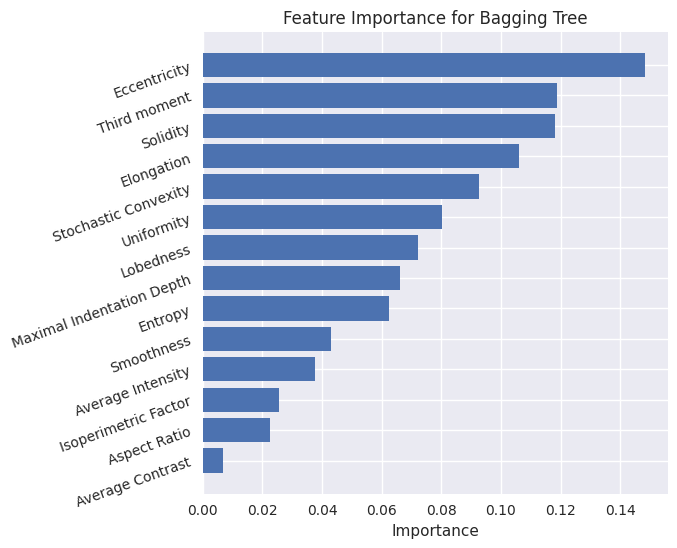

In [67]:
# Train the classifier with the best parameters
bagging_clf.fit(X_train, y_train)

# Get the feature importances
importances = bagging_clf.estimators_[0].feature_importances_

# Sort the feature importances in descending order
sorted_indices = importances.argsort()

# Get the feature names
feature_names = X_train.columns

# Plot the feature importances
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.barh((range(len(importances))), importances[sorted_indices])
plt.yticks(range(len(importances)), feature_names[sorted_indices], rotation=20)
plt.xlabel('Importance')
plt.title('Feature Importance for Bagging Tree')
plt.show()

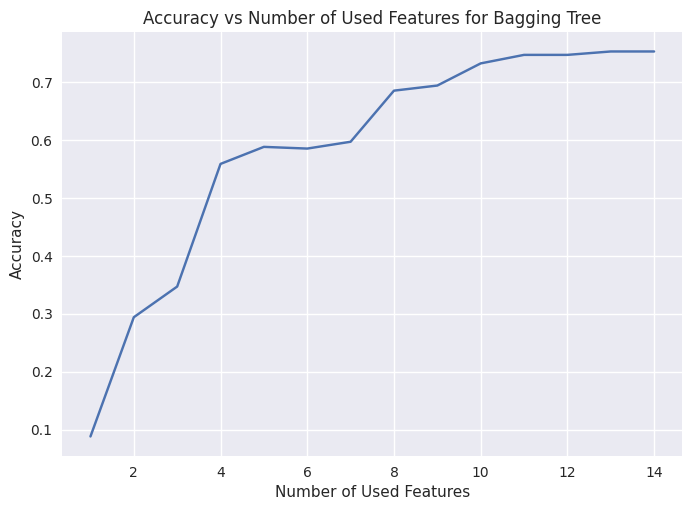

In [73]:
# Inizialization
accuracy_values = []
feature_names = feature_names[sorted_indices] 

# Loop over the number of features to be used
for num_features in range(1, len(feature_names) + 1):
    # Select the first num_features 
    selected_features = feature_names[:num_features]
    selected_df = df[selected_features]
    
    # Create the classifier
    clf = BaggingClassifier(**best_params_bagging)
    
    # We use the crossvalidation score to get the accuracy
    scores = cross_val_score(clf, selected_df, df['Class'], cv=5) 
    accuracy_values.append(scores.mean())

# Plot the accuracy vs Feature Number
plt.plot(range(1, len(feature_names) + 1), accuracy_values)
plt.xlabel('Number of Used Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Used Features for Bagging Tree')
plt.show()

# Random forest

### Simple test

In [16]:
# Create the Random Forest classifier
rf_clf = RandomForestClassifier()

# Train the classifier on the training dataset
rf_clf.fit(X_train, y_train)

# Predict the class labels for the test dataset
pred_labels = rf_clf.predict(X_test)

# Evaluate the accuracy of the bagging classifier
rf_accuracy = accuracy_score(y_test, pred_labels)
print("Tree Bagging Accuracy:", rf_accuracy)

Tree Bagging Accuracy: 0.7647058823529411


In [ ]:
# Calculate the cross-validation scores
scores = cross_val_score(rf_clf, df.drop('Class', axis=1), df['Class'], cv=5)
accuracy = scores.mean()
print(accuracy)

0.7676470588235295


### Grid search

In [6]:
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200, 600],
    'max_features': [6,8,10, 'sqrt', 'log2'],
}

# Create the Random Forest classifier
rf_clf = RandomForestClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_rf = grid_search.best_params_

# Print the best parameters 
print("Best Parameters:", best_params_rf)

Best Parameters: {'max_features': 8, 'n_estimators': 100}


### Feature importance

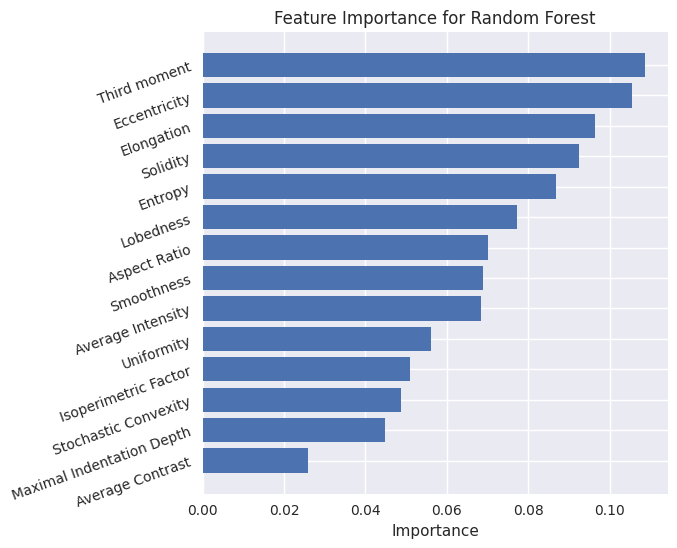

In [72]:
# Train the classifier with the best parameters
rf_clf.fit(X_train, y_train)

# Get the feature importances
importances = rf_clf.estimators_[0].feature_importances_

# Sort the feature importances in descending order
sorted_indices = importances.argsort()

# Get the feature names
feature_names = X_train.columns

# Plot the feature importances
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.barh((range(len(importances))), importances[sorted_indices])
plt.yticks(range(len(importances)), feature_names[sorted_indices], rotation=20)
plt.xlabel('Importance')
plt.title('Feature Importance for Random Forest')
plt.show()

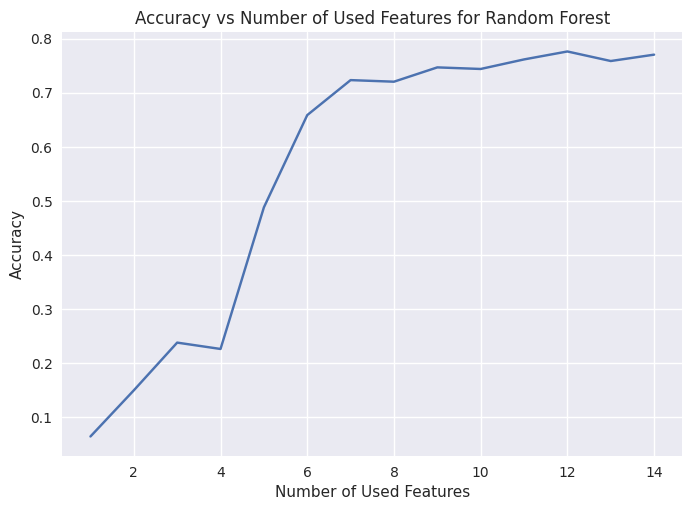

In [74]:
# Inizialization
accuracy_values = []
feature_names = feature_names[sorted_indices] 

# Loop over the number of features to be used
for num_features in range(1, len(feature_names) + 1):
    # Select the first num_features 
    selected_features = feature_names[:num_features]
    selected_df = df[selected_features]
    
    # Create the classifier
    clf = RandomForestClassifier(**best_params_rf)
    
    # We use the crossvalidation score to get the accuracy
    scores = cross_val_score(clf, selected_df, df['Class'], cv=5)
    accuracy_values.append(scores.mean())

# Plot the accuracy vs Feature Number
plt.plot(range(1, len(feature_names) + 1), accuracy_values)
plt.xlabel('Number of Used Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Used Features for Random Forest')
plt.show()

# Tree comparison


In [44]:
# Initialize the accuracy lists
accuracy1 = []
accuracy2 = []

# Define the range of n_estimators
r = range(1,500,5)

# Loop over the range of n_estimators
for i in r:
    clf1 = BaggingClassifier(n_estimators=i)
    clf2 = RandomForestClassifier(n_estimators=i)

    # Calculate the cross-validation scores
    scores = cross_val_score(clf1, df.drop(['Class'],axis=1), df['Class'], cv=5)    
    accuracy1.append(scores.mean())

    # Calculate the cross-validation scores
    scores = cross_val_score(clf2, df.drop(['Class'],axis=1), df['Class'], cv=5)    
    accuracy2.append(scores.mean())

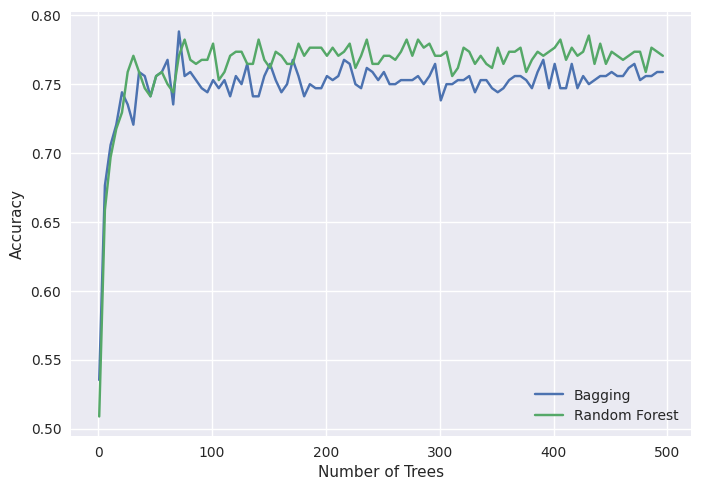

In [45]:
# Plot the accuracy vs number of trees
plt.plot(r, accuracy1, label='Bagging')
plt.plot(r, accuracy2, label='Random Forest')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Results

### Bagging Tree

In [78]:
clf = BaggingClassifier(**best_params_bagging)

# Calculate the cross-validation scores
scores = cross_val_score(clf, df.drop('Class', axis=1), df['Class'], cv=5)
accuracy = scores.mean()

# Calculate the weighted accuracy
scorer = make_scorer(balanced_accuracy_score)
scores = cross_val_score(clf, df.drop('Class', axis=1), df['Class'], cv=5, scoring=scorer)
balanced_acc = scores.mean()

# Calculate the f1 score
scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(clf, df.drop('Class', axis=1), df['Class'], cv=5, scoring=scorer)
f1 = scores.mean()


# Print the results
print("Cross Accuracy:", accuracy)
print("Weighted Accuracy:", balanced_acc)
print("F1 Score:", f1)

Cross Accuracy: 0.7558823529411764
Weighted Accuracy: 0.7611111111111111
F1 Score: 0.7236834733893558


### Random Forest

In [11]:
clf = RandomForestClassifier(**best_params_rf)

# Calculate the cross-validation scores
scores = cross_val_score(clf, df.drop('Class', axis=1), df['Class'], cv=5)
accuracy = scores.mean()

# Calculate the weighted accuracy
scorer = make_scorer(balanced_accuracy_score)
scores = cross_val_score(clf, df.drop('Class', axis=1), df['Class'], cv=5, scoring=scorer)
balanced_acc = scores.mean()

# Calculate the f1 score
scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(clf, df.drop('Class', axis=1), df['Class'], cv=5, scoring=scorer)
f1 = scores.mean()


# Print the results
print("Cross Accuracy:", accuracy)
print("Weighted Accuracy:", balanced_acc)
print("F1 Score:", f1)

Cross Accuracy: 0.7470588235294118
Weighted Accuracy: 0.7588888888888888
F1 Score: 0.7367296918767507
